# Python 3.x

In [50]:
%reload_ext version_information
%version_information numpy, nltk, matplotlib, pyspark

Software versions
Python 3.6.7 64bit [MSC v.1915 64 bit (AMD64)]
IPython 7.4.0
OS Windows 10 10.0.17134 SP0
numpy 1.16.2
nltk 3.3
matplotlib 3.0.3
pyspark 2.4.1
Fri Apr 19 02:14:43 2019 Hora est. Pacífico, Sudamérica

In [51]:
import os
assert os.environ["JAVA_HOME"] not in [None, ""]

# Windows (PySpark) args

In [52]:
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master spark://127.0.0.1:5002 pyspark-shell"

In [53]:
#!pip install --upgrade findspark
import findspark
findspark.init()

# CRISP-DM Methodology

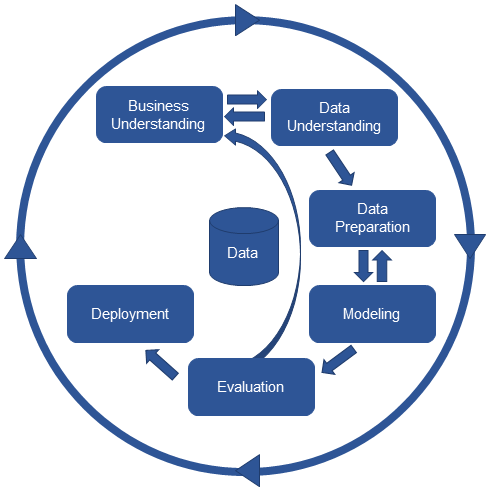

In [54]:
from IPython.display import Image
Image(filename='./crisp-dm-4-problems-fig1.png') 

# Stage 1: Businnes Understanding

## Context

La minería o analítica de texto, son un conjunto de modelos, técnicas, algoritmos y
tecnologías que permiten procesar texto de naturaleza NO ESTRUCTURADA.
<br/>
La minería de texto (text mining) permite transformar el texto en una forma
estructurada, de tal forma que facilite una serie de aplicaciones como Búsqueda en
texto, relevancia de documentos, entendimiento natural del lenguaje (NLP), traducción
automática entre idiomas, análisis de sentimientos, detección de tópicos entre muchas
otras aplicaciones.
<br/>
Quizás el procesamiento más sencillo de todos, sea el wordcount, el cual consiste en
determinar la frecuencia de la palabra por documento o por todo el dataset.

## Problem Specification

### 1.1. Data preparation

LAS NOTICIAS DEBEN SER PRE-PROCESADAS PARA PREPARAR LOS DATOS PARA LA
ANALITICA.

### 1.2. IDF

El Índice invertido es una estructura de datos que contiene la siguiente estructura:

In [55]:
from IPython.display import HTML, display
import tabulate
table = [["WORD","LIST OF NEWS(The 5 most relevant)."],
         ["word1", "[(news_1, f1), (news_7, f4), (news_11, f3), ...]."],
         ["word2", "[(news_2, f7), (news_1, f4), (news_15, f7), ...]."],
         ["word3", "[(news_8, f3), (news_12, f5), (news_17, f5), ...]."],
         ["...", "...."],
         ["wordn", "[(news_7, f7), (news_5, f12), (news_13, f12), ...]."]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

WORD,LIST OF NEWS(The 5 most relevant).
word1,"[(news_1, f1), (news_7, f4), (news_11, f3), ...]."
word2,"[(news_2, f7), (news_1, f4), (news_15, f7), ...]."
word3,"[(news_8, f3), (news_12, f5), (news_17, f5), ...]."
...,....
wordn,"[(news_7, f7), (news_5, f12), (news_13, f12), ...]."


### 1.3. Similarity analysis

Realizar agrupamiento de noticias utilizando uno de diferentes algoritmos y modelos de
clustering o similitud, de tal manera, que permita a cualquier noticia identificar que otras
noticias son similares.
<br/>
Se propone utilizar una métrica / función de similitud basado en la intersección de las
palabras comunes de mayor frecuencia por cada noticia, se sugiere tener 10 palabras más
frecuentes por noticias cuya frecuencia sea mayor que 1.

# Stage 2: Data Understanding

In [56]:
from pyspark.sql import Row, SparkSession
from pyspark.sql import SQLContext

In [57]:
sparkContext = SparkSession.builder.master("local[4]").appName("App").getOrCreate()

In [58]:
sqlContext = SQLContext(sparkContext=sparkContext.sparkContext, sparkSession=sparkContext)

## Read the Dataset

In [59]:
data_path = './../data/articles1.csv'

In [60]:
df = sqlContext.read.load(data_path, 
                            header=True, 
                            format='com.databricks.spark.csv',
                            inferSchema='true',
                            encoding='utf-8')

## Columns (Filters)

In [61]:
df.columns

['_c0',
 'id',
 'title',
 'publication',
 'author',
 'date',
 'year',
 'month',
 'url',
 'content']

## Number of Articles

In [62]:
df.count()

50004

In [63]:
un_columns = ['url', 'date', 'author', 'id', 'publication', 'year', 'month']
df[un_columns].head(10)

[Row(url=None, date='2016-12-31', author='Carl Hulse', id='17283', publication='New York Times', year='2016.0', month='12.0'),
 Row(url=None, date='2017-06-19', author='Benjamin Mueller and Al Baker', id='17284', publication='New York Times', year='2017.0', month='6.0'),
 Row(url=None, date='2017-01-06', author='Margalit Fox', id='17285', publication='New York Times', year='2017.0', month='1.0'),
 Row(url=None, date='2017-04-10', author='William McDonald', id='17286', publication='New York Times', year='2017.0', month='4.0'),
 Row(url=None, date='2017-01-02', author='Choe Sang-Hun', id='17287', publication='New York Times', year='2017.0', month='1.0'),
 Row(url=None, date='2017-01-02', author='Sewell Chan', id='17288', publication='New York Times', year='2017.0', month='1.0'),
 Row(url=None, date='2017-01-02', author='Javier C. Hernández', id='17289', publication='New York Times', year='2017.0', month='1.0'),
 Row(url=None, date='2017-02-08', author='Gina Kolata', id='17290', publicati

## NA Values

In [64]:
df.filter(df.url == None).count()

0

# Stage 3: Data Preparation

## Useful Columns

In [78]:
useful_columns = ['_c0', 'title', 'content']
useful_dataset = df[useful_columns]

In [79]:
from pyspark.sql.functions import countDistinct

In [80]:
def get_key_val(row):
    _c0 = str(row._c0)
    text1 = str(row.title)
    text2 = str(row.content)
    words1 = text1.lower().split()
    words2 = text2.lower().split()
    return [[w, _c0] for w in words1 + words2]

In [81]:
from operator import add

# Stage 4: Modeling

## Functions

In [73]:
def fun(x, y):
    x.add(y)
    return x

## TF-IDF

In [ ]:
rdd = useful_dataset.rdd.flatMap(lambda row: map(lambda word: (word, str(row._c0)), (str(row.content).lower() + " " + str(row.title).lower()).split())).map(lambda text: ((text[0], text[1]), 1)).reduceByKey(lambda c1, c2: c1 + c2).map(lambda _key: (_key[0][0], (_key[0][1], _key[1]))).aggregateByKey(set(), fun, lambda x, y: x | y)
res = rdd.collect()

## Model

### Theory

The	tf-idf weight of a term	is the product of its tf weight and its idf weight. This can be described by the following equation.

$\mathscr{W}_{(t,d)} = \log(1 + \mathscr{F_t}_{(t, d)}) \times \log(\frac{\mathscr{N}}{\mathscr{D_f}_{t}})$

# Stage 5: Model Evaluation

# (Cycle Stage 6): Go to stage 1

# Stage 7: Deployment